In [266]:
import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import *
from src.utils.pre_processing.pre_processing import *
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

material = openmc.Materials([B4C_MATERIAL, LEAD_MATERIAL, AIR_MATERIAL, STEEL_MATERIAL, CONCRETE_MATERIAL])
material.export_to_xml()


In [267]:
RADIUS_PLUG = 25
PITCH_PLUG = 55
altimetry_plug_starting = 330

In [268]:
# b4c_plug_part = openmc.ZCylinder(x0=0.0, y0=0.0, z=0.0, r=25)
height_b4c_plug_part = 50.0  # cm
height_lead_plug_part = 25.0  # cm
b4c_plug_part_cell = openmc.Cell(fill=B4C_MATERIAL, region=-openmc.ZCylinder(x0=0.0, y0=0.0, r=RADIUS_PLUG) &
                                  +openmc.ZPlane(z0=altimetry_plug_starting) &
                                  -openmc.ZPlane(z0=altimetry_plug_starting + height_b4c_plug_part))
lead_plug_part_cell = openmc.Cell(fill=LEAD_MATERIAL, region=-openmc.ZCylinder(x0=0.0, y0=0.0, r=RADIUS_PLUG) &
                                  +openmc.ZPlane(z0=altimetry_plug_starting + height_b4c_plug_part) &
                                  -openmc.ZPlane(z0=altimetry_plug_starting + height_b4c_plug_part + height_lead_plug_part))
steel_liner_plug_cell = openmc.Cell(fill=STEEL_MATERIAL, region=-openmc.ZCylinder(x0=0.0, y0=0.0, r=RADIUS_PLUG*2) &
                                     +openmc.ZPlane(z0=altimetry_plug_starting -1) &
                                     -openmc.ZPlane(z0=altimetry_plug_starting + height_b4c_plug_part + height_lead_plug_part +1) &
                                     ~b4c_plug_part_cell.region & ~lead_plug_part_cell.region)
# ajout cellule acier
plug_universe = openmc.Universe(cells=[lead_plug_part_cell, b4c_plug_part_cell, steel_liner_plug_cell])

plug_lat = openmc.HexLattice()
plug_lat.center = (0.0, 0.0)
plug_lat.pitch = (PITCH_PLUG,)
plug_lat.outer = openmc.Universe(cells=[openmc.Cell(fill=STEEL_MATERIAL)])
plug_lat.universes = [
    [plug_universe] * 18,  # 3rd ring
    [plug_universe] * 12,  # 2nd ring
    [plug_universe] * 6,   # 1st ring
    [plug_universe],       # Center
]

hex_prism_plug_assembly = -openmc.model.HexagonalPrism(edge_length=200, orientation="y", origin=(0.0, 0.0)) & +openmc.ZPlane(z0=altimetry_plug_starting -1) & -openmc.ZPlane(z0=altimetry_plug_starting + height_b4c_plug_part + height_lead_plug_part +1)

plug_assembly_main_cell = openmc.Cell(
    name="plug_assembly_cell",
    fill=plug_lat,
    region=hex_prism_plug_assembly,
)

thickness_concrete_slab_top = 150.0  # cm
concrete_slab_top_region = -openmc.model.RectangularParallelepiped(xmin=-400, xmax=400, ymin=-400, ymax=400, zmin=altimetry_plug_starting -1, zmax=altimetry_plug_starting -1 + thickness_concrete_slab_top) &  +openmc.model.HexagonalPrism(edge_length=200, orientation="y", origin=(0.0, 0.0))
concrete_slab_top_cell = openmc.Cell(
    name="concrete_slab_top_cell",
    fill=CONCRETE_MATERIAL,
    region=concrete_slab_top_region
)

air_cell = openmc.Cell(
    name="air_cell",
    fill=AIR_MATERIAL,
    region= -openmc.Sphere(r=1000) & ~plug_assembly_main_cell.region & ~concrete_slab_top_cell.region
)

In [269]:
geometry = openmc.Geometry([plug_assembly_main_cell, air_cell, concrete_slab_top_cell])
geometry.export_to_xml()

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 97
Plot file: plot_openmc_xz.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width: 1000 1000
Coloring: Cells
Basis: XZ
Pixels: 600 600

 Processing plot 97: plot_openmc_xz.png...


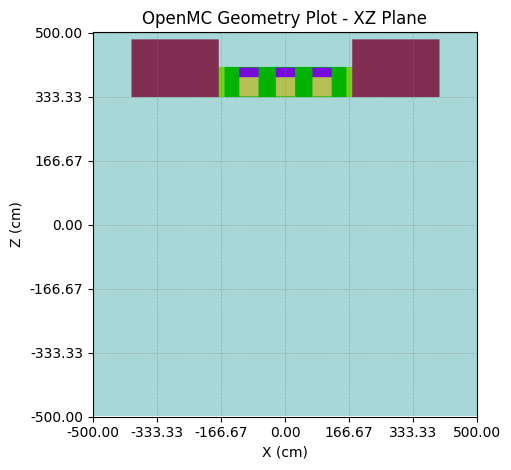

In [270]:
plot_geometry(materials = material, plane="xz", width=1000, height=1000, dpi=500, saving_figure=False, legend_materials=False, color_by="cell")

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 98
Plot file: plot_openmc_xy.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 333
Width:  500  500
Coloring: Materials
Basis: XY
Pixels: 600 600

 Processing plot 98: plot_openmc_xy.png...


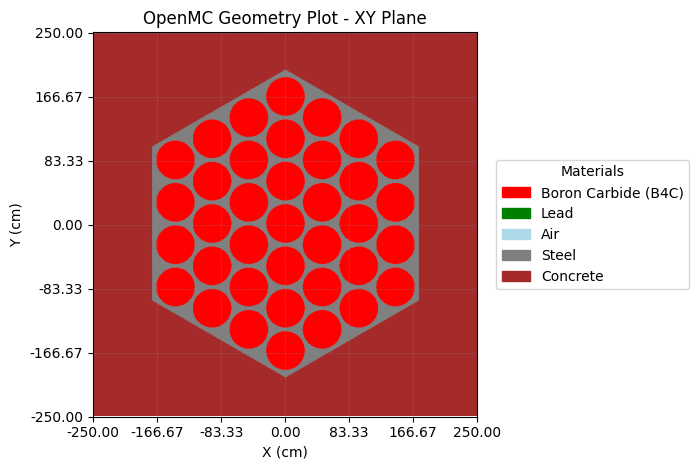

In [271]:
plot_geometry(materials = material, plane="xy",  origin=(0,0, 333), width=500, height=500, dpi=500, saving_figure=False, legend_materials=True, color_by="material")

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 99
Plot file: plot_openmc_xz.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 333
Width:  600  600
Coloring: Materials
Basis: XZ
Pixels: 600 600

 Processing plot 99: plot_openmc_xz.png...


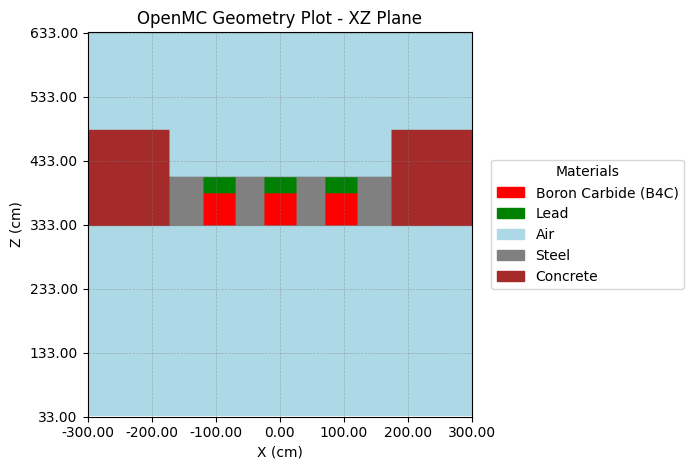

In [272]:
plot_geometry(materials = material, plane="xz", width=600, height=600, origin=(0,0,333), dpi=500, saving_figure=False, legend_materials=True, color_by="material")